In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
%matplotlib inline


# 1. Read the data

This data set which contains transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
Source: http://archive.ics.uci.edu/ml/datasets/Online+Retail



In [2]:
df = pd.read_excel("Online Retail.xlsx")

# 2. Basic exploration and data preprocessing

Let's have a look how does the data looks like:

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Number of rows and columns in data set

In [4]:
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

Number of rows in dataset is:  541909
Number of columns in dataset is:  8


Here we will get some information about datatypes of the columns and number of non zero rows in each column.
From the information bellow we can conclude that column Description and CustomerID columns contains some missing values. This fact will be examined in further steps.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
print("Number of unique customers IDs:", len(df['CustomerID'].unique().tolist()))

Number of unique customers IDs: 4373


For purposes of customer segmentation missing ids will be dropped.

From descriptive statistics of quantitative variables (Quantity and UnitPrice), we could see that there are negative values in these variables, which are not possible values for price and quantity.

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Let's have a closer look on the reason of negative values in these variables. In the description of dataset it is written that there are some canceled transactions presented in dataset. Canceled transactions is indicated by invoice number which starts with letter 'c'. Probably transactions with negative values of quantity are canceled.

Filtering transaction with invoice number started with letter 'C':

In [8]:
cancelled = df[df['InvoiceNo'].astype(str).str.contains('C')]
cancelled.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Among cancelled transactions ther are not any transaction with positive quantity

In [9]:
cancelled[cancelled['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Hovewer some transactions with negative quantity doesn't belong to cancelled:

In [10]:
print("Number of cancelled transactions:", len(cancelled))
print("Total number of transaction with negative quantity:", df[df['Quantity'] <= 0 ]['Quantity'].count())

Number of cancelled transactions: 9288
Total number of transaction with negative quantity: 10624


There are also transactions with zero price. Transactions with zero price doesn't bring usefull information to analysis, moreover mainly there are not any description for such transactions. This transactions could be deleted.

In [11]:
df[df['UnitPrice'] == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


Also there are 2 transactions with negative price. From the description we could see that these transactions were probably made as some correction, so they also should be deleted.

In [12]:
df[df['UnitPrice'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


As it was mentioned before there are some negative quantity transactions wich are not cancelled, hovewer all these transactions have 0 price.

In [13]:
 d = df[~df['InvoiceNo'].astype(str).str.contains('C')]  
print("Number of of transactions with negative quantity value among non cancelled transactions:" ,len(d[d['Quantity']<=0]))
print("Number of of transactions with zero price and negative quantity" ,len(d[(d['Quantity']<=0) & (d['UnitPrice'] == 0)]))

Number of of transactions with negative quantity value among non cancelled transactions: 1336
Number of of transactions with zero price and negative quantity 1336


Percentage of transactions which will be deleted:

In [14]:
print("Percentage of cancelled transactions:" , round(len(cancelled)/len(df)*100, 2),"%")
print("Precentage of transactions with zero or negative price" ,round(len(df[df['UnitPrice']<=0])/len(df)*100, 2),"%")

Percentage of cancelled transactions: 1.71 %
Precentage of transactions with zero or negative price 0.46 %


In [15]:
data = df[(df['UnitPrice'] > 0) & (df['Quantity']>0)]

All rows with missing descriptions are gone after deleting problematic transactiones.

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      530104 non-null object
StockCode      530104 non-null object
Description    530104 non-null object
Quantity       530104 non-null int64
InvoiceDate    530104 non-null datetime64[ns]
UnitPrice      530104 non-null float64
CustomerID     397884 non-null float64
Country        530104 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


Check and delete duplicate transactions:

In [17]:
print("Number of duplicated transactions:", len(data[data.duplicated()]))

Number of duplicated transactions: 5226


In [18]:
data.drop_duplicates(inplace = True)

Drop rows with missing customers IDs

In [19]:
 data = data.dropna(subset=['CustomerID'])

## 2.1 Descriptions

It should be taken into accoun that the same description could be written in different cases, let's convert all description into lowercase.

In [20]:
data['Description'] = data['Description'].str.lower()

In [21]:
print("Number of unique descriptions:", len(data['Description'].unique().tolist()))

Number of unique descriptions: 3877


Removing punctuations for the description:

In [22]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [23]:
data['Description'] = data['Description'].replace(to_replace=r'[^\w\s]', value='', regex=True) 

After this there are less unqiue descriptions:

In [24]:
print("Number of unique descriptions:", len(data['Description'].unique().tolist()))

Number of unique descriptions: 3867


## 2.2 Stock Codes

Stock Code should be numerical value, hovewer there are some transactions which contains only multiple letters/words,
this transactions will also be dropped

In [25]:
data = data.loc[data['StockCode'].astype(str).str[0:4].str.isdigit()]

In [26]:
len(data['StockCode'].unique().tolist())

3659

## 2.3 Dates

Adding features as year, month, month_year, day of week, hour:

In [27]:
data['month'] = data['InvoiceDate'].dt.month
data['year'] = data['InvoiceDate'].dt.year

In [28]:
data['WeekDay'] = data['InvoiceDate'].dt.day_name()

In [29]:
data['month_year'] = pd.to_datetime(data[['year', 'month']].assign(Day=1))

In [30]:
data['hour'] = data['InvoiceDate'].dt.hour

In [31]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8


Adding columns with calculation of sales:

In [32]:
data['revenue'] = data['UnitPrice'] * data['Quantity']

Dataframes for plots:

In [33]:
plot = pd.DataFrame(data.groupby(['month_year'])['InvoiceNo'].count()).reset_index()
plot2 = pd.DataFrame(data.groupby(['WeekDay'])['InvoiceNo'].count())
plot3 = pd.DataFrame(data.groupby(['hour'])['InvoiceNo'].count()).reset_index()
plot4 = pd.DataFrame(data.groupby(['month_year'])['revenue'].mean()).reset_index()
plot5 = pd.DataFrame(data.groupby(['month_year'])['revenue'].sum()).reset_index()

In [34]:
plot2 = plot2.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']).reset_index()

## How many orders per month?

There are more purchasing made at the end of the year. The highest number of transactions were made during November. Probably reason could be the fact, that people tend to prepare for Christmas during November. Other than November number of byuings during the year is quite similar.

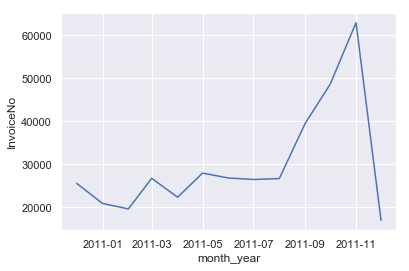

In [35]:
ax = sns.lineplot(x="month_year", y="InvoiceNo", data = plot)

## How many orders per day?

Interesting fact is that there were not any transaction on Saturday during the whole period. 
One of the explanations colud be some filter during the data collection process. Number of buyings are not significantly differ according to the day of the week.

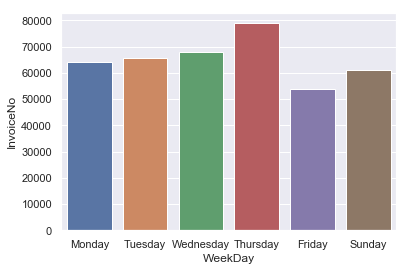

In [36]:
 ax = sns.barplot(x="WeekDay", y="InvoiceNo", data = plot2)

## How many orders per hour?

The most number of transactions is done between 12 a.m. and 2 p.m., people tend to make there purchase during the lunch time.
There aren't any transactions after 8 p.m. till 6 a.m.

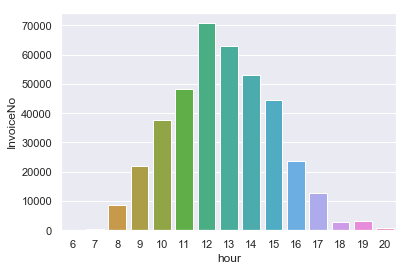

In [37]:
 ax = sns.barplot(x="hour", y="InvoiceNo", data = plot3)

## Which month brings the highest revenue?

The highest sales are also during the November, as the number of purchasing is the highest.

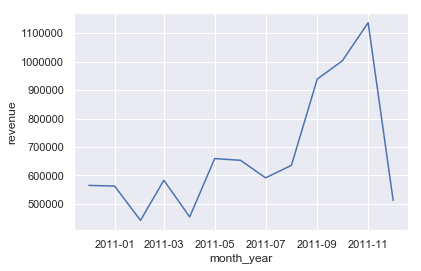

In [38]:
ax = sns.lineplot(x = 'month_year', y='revenue', data = plot5)

## 2.3 Price

From the descriptive statistics for price variable, we could see that most ot the sold products are quite cheap.
Probably retail sells some small items, as office supplies, small decorations etc.

In [39]:
pd.DataFrame(data['UnitPrice'].describe())

,UnitPrice
count,391150.000000
mean,2.874372
std,4.284738
min,0.040000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


Description of products, which cost more than 50 (Assumption: same currency for retails in different countries.)


In [40]:
data[data['UnitPrice']>50]['Description'].unique().tolist()

['rustic  seventeen drawer sideboard',
 'vintage post office cabinet',
 'vintage red kitchen cabinet',
 'regency mirror with shutters',
 'love seat antique white metal',
 'vintage blue kitchen cabinet',
 'school desk and chair ',
 'chest natural wood 20 drawers',
 'decorative hanging shelving unit',
 'picnic basket wicker 60 pieces']

## Price distribution of expensive goods :

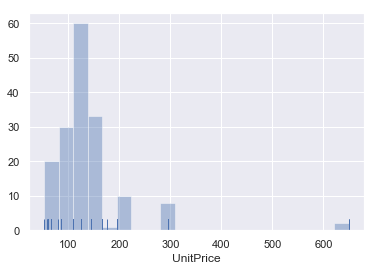

In [41]:
sns.distplot(data[data['UnitPrice']>50]['UnitPrice'], kde=False, rug=True);

## 2.3 Transactions by countries

The most unique customers are from United Kingdom, for this reason it is better to concetrate on UK for customer segmentation.

In [42]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)


,Country,CustomerID
35,United Kingdom,3916
14,Germany,94
13,France,87
30,Spain,30
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,14
12,Finland,12
1,Austria,11


In [43]:
print("Transactions were made in", len(data['Country'].unique().tolist()), "different countries")

Transactions were made in 37 different countries


In [44]:
print("Number of transactions where country is unspecified:", len(data[data['Country']=='Unspecified']))

Number of transactions where country is unspecified: 241


Dataframe for plots:

In [45]:
plot6 = pd.DataFrame(data.groupby(['Country'])['revenue'].sum()).reset_index()
plot6 = plot6.sort_values(['revenue']).reset_index(drop=True)
plot7 = pd.DataFrame(data.groupby(['Country'])['revenue'].count()).reset_index()
plot7 = plot7.sort_values(['revenue']).reset_index(drop=True)

## The most sales makes United Kingdom

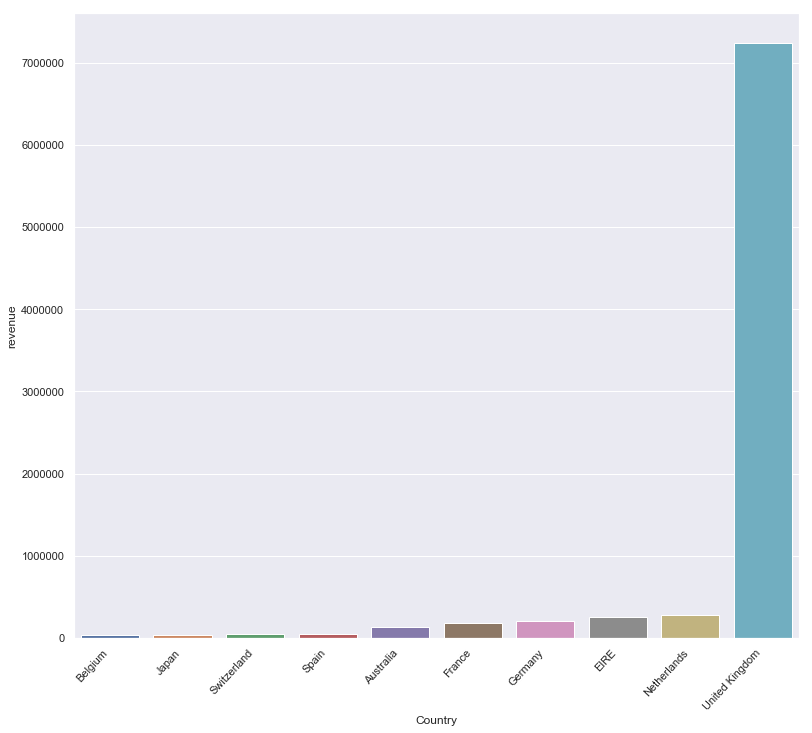

In [46]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Country', y='revenue',data=plot6.tail(10),estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

## Countries by number of orders:

The biggest number of orders are made in United Kingdom, which is expected, because the store is UK-based.


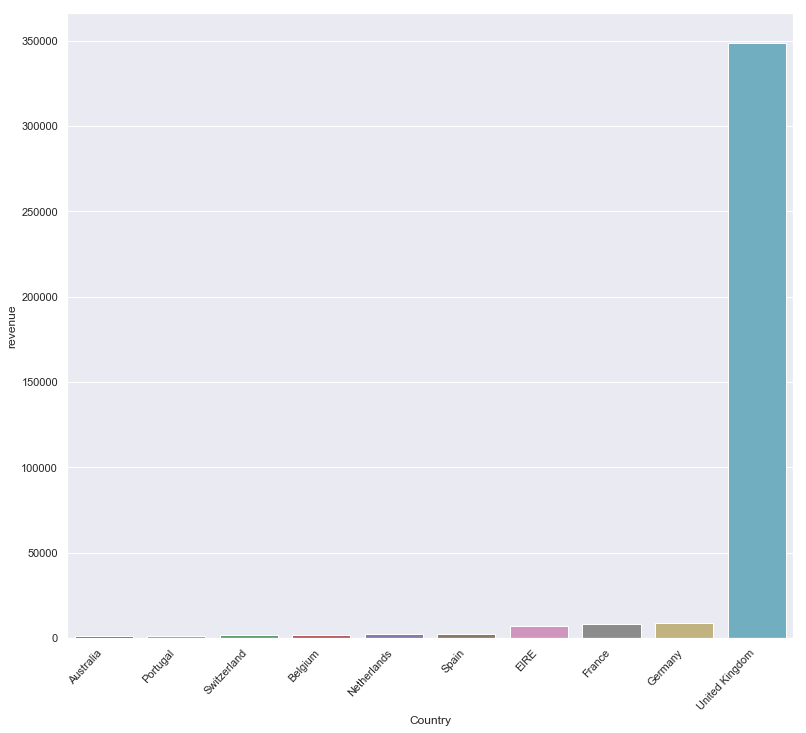

In [47]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Country', y='revenue',data=plot7.tail(10),estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

# 3. Analysis

## 3.1 Top Customers

Calculate how often did particular customer make purchase during the year:

In [48]:
data['freq'] = data.groupby('CustomerID')['CustomerID'].transform('count')

Calculate the top 500 customers who brings the highest revenue 

In [49]:
customer  = pd.DataFrame(data.groupby(['CustomerID'])['revenue'].sum().sort_values(ascending=False)).reset_index().head(10)



In [50]:
customer['CustomerID'].tolist()

[14646.0,
 18102.0,
 17450.0,
 16446.0,
 14911.0,
 12415.0,
 14156.0,
 17511.0,
 12346.0,
 16029.0]

In [51]:
top_customer = data[data['CustomerID'].isin(customer['CustomerID'].tolist())][['CustomerID', 'Country', 'revenue', 'Quantity', 'freq']]

Countries where the top customers resids

In [52]:
top_customer['Country'].unique().tolist()

['United Kingdom', 'EIRE', 'Netherlands', 'Australia']

## 3.2 RFM analysis

Select only UK customers:

In [53]:
df_uk = data[data['Country'] == "United Kingdom"]
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour,revenue,freq
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,15.30,297
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,20.34,297
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,22.00,297
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,20.34,297
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,20.34,297


In [54]:
print(df_uk['InvoiceDate'].min())
print(df_uk['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:49:00


In [55]:
import datetime as dt
presence = dt.datetime(2011,12,10)
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])

Calculate recency, frequency and monetary values:

Recency (R) as days since last purchase: How many days ago was their last purchase? Deduct most recent purchase date from today to calculate the recency value. 1 day ago? 14 days ago? 500 days ago?

Frequency (F) as total number of transactions: How many times has the customer purchased from our store? For example, if someone placed 10 orders over a period of time, their frequency is 10.

Monetary (M) as total money spent: How many $$ (or whatever is your currency of calculation) has this customer spent? Again limit to last two years – or take all time. Simply total up the money from all transactions to get the M value.

Source: https://www.putler.com/rfm-analysis/

In [56]:
rfm = df_uk.groupby('CustomerID').agg({'InvoiceDate': lambda x: (presence - x.max()).days, 'InvoiceNo': lambda x: len(x), 'revenue': lambda x: x.sum()})
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)
rfm.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'revenue': 'monetary_value'}, inplace=True)

In [57]:
rfm.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4397,31650.78
12749.0,3,198,4040.88
12820.0,3,59,942.34


Define quartiles for rfm score:

In [58]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [59]:
rfm_segments= rfm

In [60]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [61]:
rfm_segments['R_Quartile'] = rfm_segments['recency'].apply(RClass, args=('recency',quantiles,))
rfm_segments['F_Quartile'] = rfm_segments['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfm_segments['M_Quartile'] = rfm_segments['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))

In [62]:
rfm_segments['RFMClass'] = rfm_segments.R_Quartile.map(str) \
                            + rfm_segments.F_Quartile.map(str) \
                            + rfm_segments.M_Quartile.map(str)

In [63]:
rfm_segments.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12747.0,2,103,4196.01,1,1,1,111
12748.0,0,4397,31650.78,1,1,1,111
12749.0,3,198,4040.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


In [64]:
rfm_segments['RFMClass'].unique()

array(['441', '111', '122', '444', '322', '341', '333', '133', '231',
       '233', '433', '311', '212', '332', '223', '222', '324', '443',
       '321', '312', '422', '343', '344', '211', '411', '423', '112',
       '243', '142', '234', '121', '442', '221', '131', '134', '334',
       '213', '244', '143', '434', '144', '431', '113', '432', '132',
       '331', '242', '342', '424', '323', '123', '232', '224', '124',
       '412', '241', '313', '413', '421', '114', '141'], dtype=object)

In [65]:
rfm_segments.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12747.0,2,103,4196.01,1,1,1,111
12748.0,0,4397,31650.78,1,1,1,111
12749.0,3,198,4040.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


In [66]:
print("Champions: ",len(rfm_segments[rfm_segments['RFMClass']=='111']), "(", round(len(rfm_segments[rfm_segments['RFMClass']=='111'])/len(rfm_segments)*100,2), "%)") 
print('Loyal Customers: ',len(rfm_segments[rfm_segments['F_Quartile']==1]), "(", round(len(rfm_segments[rfm_segments['F_Quartile']==1])/len(rfm_segments)*100,2), "%)")
print("Big Spenders: ",len(rfm_segments[rfm_segments['M_Quartile']==1]), "(", round(len(rfm_segments[rfm_segments['M_Quartile']==1])/len(rfm_segments)*100,2), "%)")
print('About to Sleep: ', len(rfm_segments[rfm_segments['RFMClass']=='322']), "(", round(len(rfm_segments[rfm_segments['RFMClass']=='322'])/len(rfm_segments)*100,2), "%)")
print('Lost Customers: ',len(rfm_segments[rfm_segments['RFMClass']=='444']), "(", round(len(rfm_segments[rfm_segments['RFMClass']=='444'])/len(rfm_segments)*100,2), "%)")


Champions:  407 ( 10.39 %)
Loyal Customers:  967 ( 24.69 %)
Big Spenders:  979 ( 25.0 %)
About to Sleep:  147 ( 3.75 %)
Lost Customers:  340 ( 8.68 %)


## 4. Recommendations

There are problems in data collections and data integration processes which should be solved, for more effective data analysis and more clear sollutions.

1. Missing customer ID -  this column could be made not nullable, in case for treatment occurences of missing IDs.
2. Not valid Stock Codes (contains different letters/some words) - some checking constraints for stock codes.
3. Duplicate transasctions - probably data were collected from multiple sources, which caused some duplictities.
4. To each stock code should belong only one product description, this rule is not kept in dataset. The reason could be again absence of constraints or wrong joins of the tables, if the dataset were constricted from multiple tables.

Solving of problems related to data quality could significantly improve the results of algorithms.

Based on RFM analysis several customers segments from UK could be defined. There are quite big precantage of loyal customers or customers who tend to spned big amount of money while buying. Also ther groups of customers who are already lost and who are going to be lost in near future. Uqing this groups some targeting campaignes could be used.